In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import sys
import os
os.chdir(os.path.abspath("../src"))

In [4]:
import duckdb as ddb, ibis

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import pandas as pd
import math

## Constants

In [7]:
database_folder_path = '../data/duckdb'
ddb_file_name = 'intermediate_files.db'

## Functions

In [8]:
def show_values_on_bars(axs, h_v="v", space=0.8, use_percent=False, text_rotation=0):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _width = 0 if math.isnan(p.get_width()) else p.get_width()
                _height = 0 if math.isnan(p.get_height()) else p.get_height()
                _x = p.get_x() + _width / 2
                _y = p.get_y() + _height + float(space)
                value = (
                    f"{round(_height, 2)}"
                    if not use_percent
                    else f"{round(_height, 2)}%"
                )
                ax.text(
                    _x,
                    _y,
                    value,
                    ha="center",
                    rotation=text_rotation,
                    fontweight="bold",
                )
        elif h_v == "h":
            for p in ax.patches:
                _width = 0 if math.isnan(p.get_width()) else p.get_width()
                _height = 0 if math.isnan(p.get_height()) else p.get_height()
                _x = p.get_x() + _width + float(space)
                _y = p.get_y() + _height
                value = (
                    f"{round(_width, 2)}" if not use_percent else f"{round(_width, 2)}%"
                )
                ax.text(_x, _y, value, ha="left", fontweight="bold")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndnumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


def create_multiple_plots(
    df,
    x,
    y,
    hue=None,
    col=None,
    col_order=None,
    row=None,
    order=None,
    hue_order=None,
    hue_color_dict=None,
    kind="line",
    orientation="v",
    text_rotation=0,
    marker="o",
    title=None,
    height=5,
    aspect=1,
    use_percent=False,
    space=0.8,
    ref_value_dict=None,
    bins=None
):
    if kind == "line":
        graph = sns.relplot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            kind=kind,
            height=height,
            aspect=aspect,
            marker=marker,
            hue_order=hue_order,
            palette=hue_color_dict,
            col_order = col_order,
            facet_kws=dict(sharex=False, sharey=False),
        )
    elif kind == "bar":
        graph = sns.catplot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            kind=kind,
            height=height,
            aspect=aspect,
            hue_order=hue_order,
            palette=hue_color_dict,
            sharex=False,
            order=order,
        )
    elif kind == "point":
        graph = sns.catplot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            kind=kind,
            height=height,
            aspect=aspect,
            hue_order=hue_order,
            palette=hue_color_dict,
            sharex=False,
            sharey=False,
            order=order,
        )
    elif (kind == "box") or (kind == "violin"):
        graph = sns.catplot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            kind=kind,
            height=height,
            aspect=aspect,
            order=order,
            hue_order=hue_order,
            palette=hue_color_dict,
            sharex=False,
            sharey=True,
            col_order=col_order
        )
    elif kind == "hist":
        graph = sns.displot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            hue_order=hue_order,
            kind=kind,
            height=height,
            aspect=aspect,
            facet_kws=dict(sharex=False, sharey=False),
            palette=hue_color_dict,
            stat="probability",
            bins=bins,
            alpha=0.5,
        )
    elif kind == "kde":
        graph = sns.displot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            hue_order=hue_order,
            kind=kind,
            height=height,
            aspect=aspect,
            facet_kws=dict(sharex=False, sharey=False),
            palette=hue_color_dict,
        )

    if ref_value_dict is not None:
        print(ref_value_dict)
        if "x" in ref_value_dict:
            graph.refline(x=ref_value_dict.get("x"), color="red", lw=3)
        if "y" in ref_value_dict:
            graph.refline(y=ref_value_dict.get("y"), color="blue", lw=3)

    if title is not None:
        graph.fig.subplots_adjust(top=0.8)
        graph.fig.suptitle(title, fontsize=20)

    for axes in graph.axes.flat:
        if kind == "bar" and orientation == "h":
            _ = axes.set_yticklabels(axes.get_yticklabels(), rotation=0)
            show_values_on_bars(axes, orientation, space, use_percent=use_percent)
        else:
            _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
            if kind == "bar":
                show_values_on_bars(
                    axes,
                    orientation,
                    space,
                    use_percent=use_percent,
                    text_rotation=text_rotation,
                )

    plt.subplots_adjust(hspace=2.2)
    return graph

In [9]:
def plot_graphs_by_looping(df, row_identifier, column_identifier, x_column_to_plot, y_column_to_plot, row_count, max_column_count):
    fig, axs = plt.subplots(row_count,max_column_count, figsize=[5*max_column_count,5*row_count]) ##, figsize=[20,20]
    fig.subplots_adjust(wspace=1.0, hspace=0.5)
    
    for i, continent_name in enumerate(df[row_identifier].unique()):
        continent_count_df = df[df[row_identifier] == continent_name]
        for j, sub_continent_name in enumerate(continent_count_df[column_identifier].unique()):
            sub_continent_count_df = continent_count_df[continent_count_df[column_identifier] == sub_continent_name]
            sns.barplot(data=sub_continent_count_df, x=x_column_to_plot, y=y_column_to_plot, ax=axs[i][j])
            axs[i][j].title.set_text(f"{sub_continent_name}")
    plt.close()
    return fig

In [10]:
def get_row_column_count_in_ddb_table(con, table_name):
    row_count_df = con.execute(f"select count(*) as row_count from {table_name};").df()
    row_count = row_count_df['row_count'].loc[0]

    column_count_df = con.execute(f"select count(*) as column_count from information_schema.columns where table_name = '{table_name}';").df()
    column_count = column_count_df['column_count'].loc[0]
    return (row_count, column_count)

In [11]:
def get_counts_for_column_entries_ddb_table(con, table_name, count_column_name, group_by_column_list, is_distinct_count=False):
    if isinstance(group_by_column_list, list):
        group_by_column_name = ','.join(group_by_column_list)

    if not is_distinct_count:
        ## #con.execute(f"select geo_network_continent, geo_network_sub_continent, count(*) from intermediate_train_data group by geo_network_continent, geo_network_sub_continent").df()
        count_df = con.execute(f"select {group_by_column_name}, count(*) AS row_count_{count_column_name} FROM {table_name} GROUP BY {group_by_column_name} ORDER BY row_count_{count_column_name} DESC;").df()
        return count_df
    else:
        ##select full_visitor_id, COUNT(DISTINCT(channel_grouping)) AS unique_channel_grouping from intermediate_train_data GROUP BY full_visitor_id
        unique_count_df = con.execute(f"select {group_by_column_name}, COUNT(DISTINCT({count_column_name})) AS unique_count_{count_column_name} FROM {table_name} GROUP BY {group_by_column_name} ORDER BY unique_count_{count_column_name} DESC;").df()
        return unique_count_df

In [12]:
def get_separator_separated_values_for_column(con, table_name, count_column_name, group_by_column_name, is_distinct_count=False, separator=','):
    if is_distinct_count:
        res_df = con.execute(f"select {group_by_column_name}, array_to_string(list_sort(string_split(STRING_AGG(DISTINCT({count_column_name}), '{separator}'), '{separator}')), '{separator}') AS concatenated_unique_{count_column_name} from {table_name} group by {group_by_column_name}").df()
        return res_df

In [81]:
def get_aggregates_for_numerical_variable_using_groupby_column(con, table_name, numeric_column_name, group_by_column_list, is_per_session=True):
    if isinstance(group_by_column_list, list):
        group_by_column_name = ','.join(group_by_column_list)
    if is_per_session:
        return con.execute(f"select {group_by_column_name}, min(CAST({numeric_column_name} AS DOUBLE)) AS min_{numeric_column_name}_per_session, max(CAST({numeric_column_name} AS DOUBLE)) AS max_{numeric_column_name}_per_session, avg(CAST({numeric_column_name} AS DOUBLE)) AS avg_{numeric_column_name}_per_session, median(CAST({numeric_column_name} AS DOUBLE)) AS median_{numeric_column_name}_per_session, COUNT(*) AS row_count from {table_name} group by {group_by_column_name};").df()

## Create a connection to duckdb file and register intermediate data that is the result of handle_raw_data pipeline

In [15]:
#con = ibis.duckdb.connect(database=os.path.join(database_folder_path, ddb_file_name), read_only=True)
con = ddb.connect(database=os.path.join(database_folder_path, ddb_file_name), read_only=True)

In [16]:
intermediate_data_table = con.table('intermediate_train_data')

In [17]:
#intermediate_data_table = con.table('intermediate_train_data')
print(f"Shape of table: {get_row_column_count_in_ddb_table(con, 'intermediate_train_data')}")
#print(f'Shape of intermediate_data_table: {(intermediate_data_table.count().execute(), len(intermediate_data_table.schema()))}')

Shape of table: (1708337, 58)


## One row in the dataset refers to one visit to the Google Store. 

## Analyze different columns

### 1. Analyse channel_grouping column

### 1.1 How many rows have a given channel_grouping value associated with them?

In [ ]:
channel_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='channel_grouping', group_by_column_list=['channel_grouping'])

In [ ]:
# channel_df = intermediate_data_table['channel_grouping'].value_counts().execute()
# channel_df = channel_df.sort_values(by=['channel_grouping_count'], ascending=False)

In [ ]:
create_multiple_plots(df=channel_df, x='channel_grouping', y='row_count_channel_grouping', kind='bar', orientation='v')

- Most common channel_grouping is Organic Search. It will be nice to see how it changes fir a person.

### 1.2 How many unique channel_grouping values are associated with a user identified by full_visitor_id

In [ ]:
unique_channel_grouping_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='channel_grouping', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [ ]:
unique_channel_grouping_per_user_df['unique_count_channel_grouping'].value_counts()

- This shows that majority of visitors (1291102) use only 1 unique channel_grouping. Only 1 person uses 6 channel groupings.

### 1.3 What are the comma separated unique channel_grouping values associated with each full_visitor_id

In [ ]:
#res_df = con.execute(f"select full_visitor_id, STRING_AGG(DISTINCT(channel_grouping), ',') AS concatenated_unique_channel_grouping from intermediate_train_data group by full_visitor_id").df()
unique_channel_grouping_string_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='channel_grouping', group_by_column_name='full_visitor_id', is_distinct_count=True, separator=',')

In [ ]:
merged_unique_channel_grouping_string_df = pd.merge(unique_channel_grouping_string_df, unique_channel_grouping_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='left')

In [ ]:
merged_unique_channel_grouping_string_df[merged_unique_channel_grouping_string_df.unique_count_channel_grouping == 1]['concatenated_unique_channel_grouping'].value_counts()

- Clearly, Organic Search is the most common channel via which users arrive at the GStore for the users who have one unique channel_grouping associated with them

### 2. Analyse social_engagement_type column [REMOVE THIS COLUMN]

In [ ]:
social_engagement_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='social_engagement_type', group_by_column_list=['social_engagement_type'])

In [ ]:
social_engagement_df

- Clearly all the rows have common value Not Socially Engaged. Delete this column

### 3. Analyze visit_number column (An identifier for this session. It is unique for a visitor. It can help to understand how many sessions a given visitor was involved in)

### 3.1 How many unique visit_number values are associated with a user identified by full_visitor_id

In [45]:
unique_visit_number_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='visit_number', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [46]:
unique_visit_number_per_user_df.head()

,full_visitor_id,unique_count_visit_number
0,1957458976293878100,400
1,7282998257608986241,315
2,3884810646891698298,268
3,7477638593794484792,218
4,824839726118485274,209


### 3.2 Quartile analysis of unique_count_visit_number

In [48]:
unique_visit_number_per_user_df.unique_count_visit_number.describe()

count    1.329434e+06
mean     1.281251e+00
std      1.520005e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.000000e+02
Name: unique_count_visit_number, dtype: float64

- It is clear from the graph that 75% of users have 1 session associated with them.  

/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/qr/cmfkzy495k7b3bn80b7ygs080000gn/T/ipykernel_10023/2696475345.py:181: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


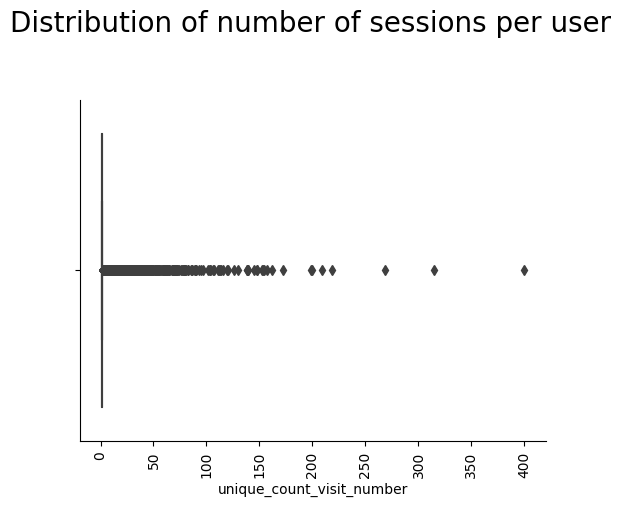

In [49]:
create_multiple_plots(df=unique_visit_number_per_user_df, x='unique_count_visit_number', y=None, kind='box', title='Distribution of number of sessions per user')

/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/qr/cmfkzy495k7b3bn80b7ygs080000gn/T/ipykernel_10023/2696475345.py:181: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


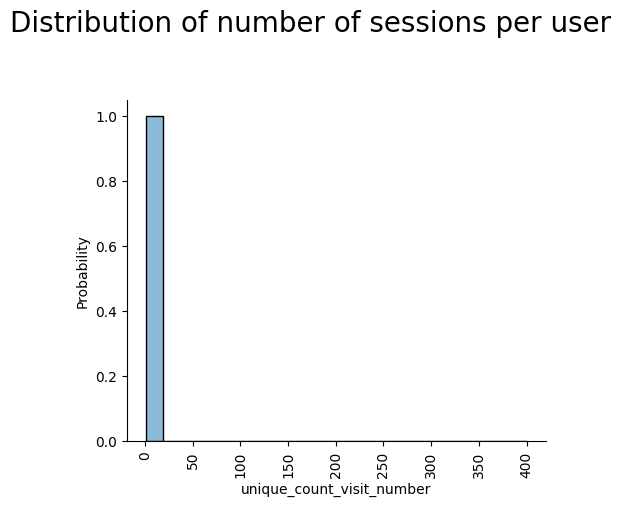

In [50]:
create_multiple_plots(df=unique_visit_number_per_user_df, x='unique_count_visit_number', y=None, kind='hist', bins='auto', title='Distribution of number of sessions per user')

- It is clear that the number of sessions per user is heavily right skewed i.e. lumped on the left with tail at the right

## 4. Analyse visit_start_time (The timestamp (expressed as POSIX time))

In [ ]:
#con.execute("select TO_TIMESTAMP(visit_start_time) AS utc_visit_start_time, date, geo_network_continent, geo_network_sub_continent, geo_network_country, geo_network_region, geo_network_city, totals_transactions	 from intermediate_train_data").df()

## 5. Analyze geo_network_continent

### 5.1 How many rows have a given geo_network_continent value associated with them?

In [ ]:
geo_network_continent_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_continent', group_by_column_list=['geo_network_continent'])

In [ ]:
create_multiple_plots(df=geo_network_continent_df, x='geo_network_continent', y='row_count_geo_network_continent', kind='bar', orientation='v')

- Clearly majority if visits are from Americas

### 5.2 How many unique geo_network_continent values are associated with a user identified by full_visitor_id

In [ ]:
unique_geo_network_continent_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_continent', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [ ]:
unique_geo_network_continent_per_user_df.unique_count_geo_network_continent.value_counts()

- This shows that majority of full_visitor_id are associated with only one continent. However, there are certain  full_visitor_id that are associated with multiple unique geo_network_continent values
- This implies that we cannot assume that full_visitor_id is linked to only one continent.

### 5.3 What are the comma separated unique geo_network_continent values associated with each full_visitor_id?

In [ ]:
unique_geo_network_continent_string_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='geo_network_continent', group_by_column_name='full_visitor_id', is_distinct_count=True, separator=',')

In [ ]:
merged_unique_geo_network_continent_string_df = pd.merge(unique_geo_network_continent_string_df, unique_geo_network_continent_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='left')

In [ ]:
merged_unique_geo_network_continent_string_df[merged_unique_geo_network_continent_string_df.unique_count_geo_network_continent == 1]['concatenated_unique_geo_network_continent'].value_counts()

## 6. Analyze geo_network_sub_continent

### 6.1 Get continent to subcontinent mapping 

In [ ]:
continent_subcontinent_mapping_df = con.execute(f"select DISTINCT(geo_network_continent, geo_network_sub_continent) AS continent_dict from intermediate_train_data;").df()

In [ ]:
continent_subcontinent_mapping_df.loc[:, ['geo_network_continent', 'geo_network_sub_continent']] = continent_subcontinent_mapping_df.apply(lambda row: row.continent_dict, axis='columns', result_type='expand')

In [ ]:
geo_network_continent_sub_continent_mapping = dict(zip(continent_subcontinent_mapping_df.geo_network_sub_continent.values, continent_subcontinent_mapping_df.geo_network_continent.values))

### 6.2 How many rows have a given geo_network_sub_continent value associated with them?

In [ ]:
geo_network_sub_continent_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_sub_continent', group_by_column_list=['geo_network_sub_continent'])

In [ ]:
#geo_network_sub_continent_df['geo_network_continent'] = geo_network_sub_continent_df['geo_network_sub_continent'].map(geo_network_continent_sub_continent_mapping)

In [ ]:
create_multiple_plots(df=geo_network_sub_continent_df, y='geo_network_sub_continent', x='row_count_geo_network_sub_continent', kind='bar', orientation='h', title='Number of rows belonging to each sub continent')

### 6.3 How many rows have a given (geo_network_sub_continent, geo_network_sub_continent) value associated with them?

In [ ]:
geo_network_continent_and_sub_continent_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_sub_continent', group_by_column_list=['geo_network_continent', 'geo_network_sub_continent'], is_distinct_count=False)
#con.execute(f"select geo_network_continent, geo_network_sub_continent, count(*) from intermediate_train_data group by geo_network_continent, geo_network_sub_continent").df()

In [ ]:
geo_network_continent_and_sub_continent_df['combine_continent_sub_continent'] = geo_network_continent_and_sub_continent_df['geo_network_continent'] + '_' + geo_network_continent_and_sub_continent_df['geo_network_sub_continent']

In [ ]:
create_multiple_plots(df=geo_network_continent_and_sub_continent_df.sort_values(by=['combine_continent_sub_continent']), y='combine_continent_sub_continent', x='row_count_geo_network_sub_continent', kind='bar', orientation='h', title='Number of rows belonging to each sub continent')

- It can be seen that Northern America has highest number of rows in the dataset

### 6.4 How many unique geo_network_sub_continent values are associated with a user identified by full_visitor_id

In [ ]:
unique_geo_network_sub_continent_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_sub_continent', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [ ]:
unique_geo_network_sub_continent_per_user_df.unique_count_geo_network_sub_continent.value_counts()

- Clearly, majority of people/ visitors are associated with 1 unique sub continenet. However, we see 1 person who has 5 unique sub continents

### 6.5 What are the comma separated unique geo_network_sub_continent values associated with each full_visitor_id?

In [ ]:
unique_geo_network_sub_continent_string_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='geo_network_sub_continent', group_by_column_name='full_visitor_id', is_distinct_count=True, separator=',')

In [ ]:
merged_unique_geo_network_sub_continent_string_df = pd.merge(unique_geo_network_sub_continent_string_df, unique_geo_network_sub_continent_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='left')

In [ ]:
merged_unique_geo_network_sub_continent_string_df[merged_unique_geo_network_sub_continent_string_df.unique_count_geo_network_sub_continent == 1]['concatenated_unique_geo_network_sub_continent'].value_counts()

- This shows that a lot of visitors who belong to exactly 1 geo_network_sub_continent are in Northern America

## 7. Analyze geo_network_country

### 7.1 How many rows have a given geo_network_country value associated with them?

In [ ]:
geo_network_country_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_country', group_by_column_list=['geo_network_continent', 'geo_network_sub_continent', 'geo_network_country'])

In [ ]:
geo_network_country_df.head()

In [ ]:
row_count = geo_network_country_df['geo_network_continent'].nunique()
max_column_count = geo_network_country_df.groupby(by=['geo_network_continent']).agg({'geo_network_sub_continent':'nunique'})['geo_network_sub_continent'].max()

In [ ]:
plot_graphs_by_looping(df=geo_network_country_df, row_identifier='geo_network_continent', column_identifier='geo_network_sub_continent', x_column_to_plot='row_count_geo_network_country', y_column_to_plot='geo_network_country', row_count=row_count, max_column_count=max_column_count)

- This graph shows number of rows belonging to each country in a given sub continent. Each row represents a continent

## 8. Analyze geo_network_region

In [ ]:
geo_network_region_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_region', group_by_column_list=['geo_network_region'])

In [ ]:
geo_network_region_df['percent_geo_network_region'] = geo_network_region_df['row_count_geo_network_region']/geo_network_region_df['row_count_geo_network_region'].sum()

In [ ]:
geo_network_region_df.head()

- 54% of rows do not have geo_network_region set. Hence delete this column

## 8. Analyze geo_network_metro

In [ ]:
geo_network_metro_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_metro', group_by_column_list=['geo_network_metro'])

In [ ]:
geo_network_metro_df['percent_geo_network_metro'] = geo_network_metro_df['row_count_geo_network_metro']/geo_network_metro_df['row_count_geo_network_metro'].sum()

In [ ]:
geo_network_metro_df.head()

- Delete column geo_network_metro as 76% rows do not have thsis value.

## 9. Analyze geo_network_city/geo_network_city_id

In [ ]:
geo_network_city_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_city', group_by_column_list=['geo_network_city'])

In [ ]:
geo_network_city_df['percent_geo_network_city'] = geo_network_city_df['row_count_geo_network_city']/geo_network_city_df['row_count_geo_network_city'].sum()

In [ ]:
geo_network_city_df

- Delete column geo_network_city as 54% rows do not have this value.

## 10. Analyze geo_network_network_domain

In [ ]:
geo_network_network_domain_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_network_domain', group_by_column_list=['geo_network_network_domain'])

In [ ]:
geo_network_network_domain_df['domain'] = geo_network_network_domain_df['geo_network_network_domain'].str.split('.').str[1]

In [ ]:
geo_network_network_domain_df.head()

- Delete column geo_network_network_domain

## 11. Analyze geo_network_latitude

In [ ]:
intermediate_data_table.geo_network_latitude

- Delete column geo_network_latitude

## 11. Analyze geo_network_longitude

In [ ]:
intermediate_data_table.geo_network_longitude

## 11. Analyze geo_network_network_location

In [ ]:
geo_network_network_location_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_network_location', group_by_column_list=['geo_network_network_location'])

In [ ]:
geo_network_network_location_df

## 12. Analyze device_browser
- Relevant device browser: chrome, safari, firefox, internet_explorer, (android_webview, android_browser, android_runtime), edge, samsung_internet, (opera_mini, opera, samsung-sm-b355e_opera), safari_(in-app), uc_browser, yabrowser, amazon_silk, coc_coc, (mozilla_compatible_agent, mozilla), mrchrome, maxthon, puffin, blackberry, nintendo_browser, (nokia_browser, nokiae52), iron, seamonkey, seznam, apple-iphone7c2, playstation_vita_browser, lunascape, konqueror, netscape, mqqbrowser, dillo

In [ ]:
device_browser_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_browser', group_by_column_list=['device_browser'])

In [ ]:
device_browser_df['normalized_device_browser'] = device_browser_df['device_browser'].str.lower().str.split(' ').str.join('_')

In [ ]:
device_browser_df.head()

## 13. Analyze device_browser_version

In [ ]:
device_browser_version_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_browser_version', group_by_column_list=['device_browser_version'])

In [ ]:
device_browser_version_df

- Delete column device_browser_version

## 14. Analyze device_browser_size

In [ ]:
device_browser_size_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_browser_size', group_by_column_list=['device_browser_size'])

In [ ]:
device_browser_size_df

## 15. Analyze device_operating_system

In [ ]:
device_operating_system_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_operating_system', group_by_column_list=['device_operating_system'])

In [ ]:
device_operating_system_df.head()

### 15.1 How many unique device_operating_system values are associated with a given visitor?

In [ ]:
unique_device_operating_system_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_operating_system', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [ ]:
unique_device_operating_system_per_user_df.unique_count_device_operating_system.value_counts()

- Majority of visitors use only one operating system. Very rarely does it go beyond 1

### 15.2 What are the comma separated unique device_operating_system values associated with each full_visitor_id?

In [ ]:
unique_device_operating_system_string_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='device_operating_system', group_by_column_name='full_visitor_id', is_distinct_count=True, separator=',')

In [ ]:
merged_unique_device_operating_system_string_df = pd.merge(unique_device_operating_system_string_df, unique_device_operating_system_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='left')

In [ ]:
merged_unique_device_operating_system_string_df[merged_unique_device_operating_system_string_df.unique_count_device_operating_system.isin([3, 4])]

## 16. Analyze device_operating_system_version

In [ ]:
device_operating_system_version_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_operating_system_version', group_by_column_list=['device_operating_system_version'])

In [ ]:
device_operating_system_version_df

- Delete device_operating_system_version column

## 17. Analyze device_is_mobile

In [ ]:
device_is_mobile_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_is_mobile', group_by_column_list=['device_is_mobile'])

In [ ]:
device_is_mobile_df

In [ ]:
unique_device_operating_system_system_per_device_is_mobile_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='device_operating_system', group_by_column_name='device_is_mobile', is_distinct_count=True, separator=',')

In [ ]:
unique_device_operating_system_system_per_device_is_mobile_df.loc[0]['concatenated_unique_device_operating_system']

In [ ]:
unique_device_operating_system_system_per_device_is_mobile_df.loc[1]['concatenated_unique_device_operating_system']

## 18. Analyze device_mobile_device_branding

In [ ]:
device_mobile_device_branding_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_device_branding', group_by_column_list=['device_mobile_device_branding'])

In [ ]:
device_mobile_device_branding_df

## 19. Analyze device_mobile_device_model

In [ ]:
device_mobile_device_model_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_device_model', group_by_column_list=['device_mobile_device_model'])

In [ ]:
device_mobile_device_model_df

## 20. Analyze device_mobile_input_selector

In [ ]:
device_mobile_input_selector_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_input_selector', group_by_column_list=['device_mobile_input_selector'])

In [ ]:
device_mobile_input_selector_df

## 21. Analyze device_mobile_device_info

In [ ]:
device_mobile_device_info_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_device_info', group_by_column_list=['device_mobile_device_info'])

In [ ]:
device_mobile_device_info_df

## 22. Analyze device_mobile_device_marketing_name

In [ ]:
device_mobile_device_marketing_name_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_device_marketing_name', group_by_column_list=['device_mobile_device_marketing_name'])

In [ ]:
device_mobile_device_marketing_name_df

## 23. Analyze device_flash_version

In [ ]:
device_flash_version_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_flash_version', group_by_column_list=['device_flash_version'])

In [ ]:
device_flash_version_df

## 23. Analyze device_language

In [ ]:
device_language_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_language', group_by_column_list=['device_language'])

In [ ]:
device_language_df

## 23. Analyze device_screen_colors

In [ ]:
device_screen_colors_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_screen_colors', group_by_column_list=['device_screen_colors'])

In [ ]:
device_screen_colors_df

## 23. Analyze device_screen_resolution

In [ ]:
device_screen_resolution_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_screen_resolution', group_by_column_list=['device_screen_resolution'])

In [ ]:
device_screen_resolution_df

## 24. Analyze device_device_category

In [ ]:
device_device_category_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_device_category', group_by_column_list=['device_device_category'])

In [ ]:
device_device_category_df

### 24.4 How many unique device_device_category values are associated with a user identified by full_visitor_id

In [ ]:
unique_device_device_category_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_device_category', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [ ]:
unique_device_device_category_per_user_df.unique_count_device_device_category.value_counts()

- Very interseting to see that every visitor uses only 1 unique device_device_category

## 25. Analyze totals - This section contains aggregate values across the session [TODO AGAIN CORRECTLY]
- https://www.digishuffle.com/blogs/google-analytics-sessions-hits-metric-simplified/
- https://themeisle.com/blog/page-views-vs-visits/#gref

1. Page View: A page view occurs whenever someone loads your site in their web browser (not necessary to be from external source). A view is registered every time a page is loaded. 
2. Page Visit: A page visit happens whenever someone reaches your site from an external source, outside of your website’s domain. For instance, if a user finds your article online and then reloads the page, that still counts as one visit. However, if they navigate away from your website, search for a new keyword in Google, and then land on your page again, this will count as two visits
3. Session: A session is the total time a user spends on your website within a certain period. A session typically expires after 30 minutes of inactivity. A session is a group of user interactions with your website that take place within a given time frame

Note: Contrary to popular belief, high page views don’t always mean you’re reaching a broad audience. High page visits are generally positive, as they indicate that your website is popular.

### 25.1 totals_visits

In [82]:
totals_visits_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_visits', ['full_visitor_id'])

In [83]:
totals_visits_per_user_aggregates_df

,full_visitor_id,min_totals_visits_per_session,max_totals_visits_per_session,avg_totals_visits_per_session,median_totals_visits_per_session,row_count
0,1188438204350710034,1.0,1.0,1.0,1.0,1
1,4995584940873803432,1.0,1.0,1.0,1.0,13
2,9431335736445969971,1.0,1.0,1.0,1.0,11
3,5545356997493092750,1.0,1.0,1.0,1.0,1
4,4725525313554504933,1.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...
1329429,3552107227896433118,1.0,1.0,1.0,1.0,1
1329430,3579436755175972276,1.0,1.0,1.0,1.0,1
1329431,4113481277117785673,1.0,1.0,1.0,1.0,1
1329432,5986748383523874055,1.0,1.0,1.0,1.0,1


In [84]:
totals_visits_per_user_aggregates_df.min_totals_visits_per_session.describe()

count    1329434.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: min_totals_visits_per_session, dtype: float64

In [85]:
totals_visits_per_user_aggregates_df.max_totals_visits_per_session.describe()

count    1329434.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: max_totals_visits_per_session, dtype: float64

In [86]:
totals_visits_per_user_aggregates_df.avg_totals_visits_per_session.describe()

count    1329434.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: avg_totals_visits_per_session, dtype: float64

In [87]:
totals_visits_per_user_aggregates_df.row_count.describe()

count    1.329434e+06
mean     1.285011e+00
std      1.529400e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.000000e+02
Name: row_count, dtype: float64

In [88]:
totals_visits_per_user_aggregates_df[totals_visits_per_user_aggregates_df.row_count == 400]

,full_visitor_id,min_totals_visits_per_session,max_totals_visits_per_session,avg_totals_visits_per_session,median_totals_visits_per_session,row_count
166850,1957458976293878100,1.0,1.0,1.0,1.0,400


- This shows that each visitor/full_visitor_id has exactly 1 visit per session. Even the visitor having 400 sessions, has maximum of 1 visit across each of 400 sessions.

### 25.2 totals_pageviews

In [93]:
totals_pageviews_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_pageviews', ['full_visitor_id'])

In [97]:
totals_pageviews_per_user_aggregates_df[totals_pageviews_per_user_aggregates_df.row_count>200]

,full_visitor_id,min_totals_pageviews_per_session,max_totals_pageviews_per_session,avg_totals_pageviews_per_session,median_totals_pageviews_per_session,row_count
167069,1957458976293878100,1.0,483.0,18.517500,5.0,400
167318,824839726118485274,1.0,94.0,11.114833,4.0,209
168332,3884810646891698298,1.0,2.0,1.044776,1.0,268
667786,7282998257608986241,1.0,115.0,4.698413,2.0,315
1002210,3608475193341679870,1.0,38.0,1.626866,1.0,201
1164224,7477638593794484792,1.0,28.0,1.619266,1.0,218


### 25.3 totals_hits

In [95]:
totals_hits_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_hits', ['full_visitor_id'])

In [96]:
totals_hits_per_user_aggregates_df[totals_hits_per_user_aggregates_df.row_count>200]

,full_visitor_id,min_totals_hits_per_session,max_totals_hits_per_session,avg_totals_hits_per_session,median_totals_hits_per_session,row_count
166882,1957458976293878100,1.0,483.0,20.982500,6.0,400
167252,824839726118485274,1.0,114.0,13.803828,4.0,209
168519,3884810646891698298,1.0,2.0,1.044776,1.0,268
665270,7282998257608986241,1.0,155.0,5.307937,2.0,315
998590,3608475193341679870,1.0,57.0,1.835821,1.0,201
1164032,7477638593794484792,1.0,34.0,1.793578,1.0,218


- Clearly, there are some people who have a large distribution of hits per session.

In [99]:
res = con.execute("select CAST (totals_hits AS DOUBLE) AS totals_hits from intermediate_train_data where full_visitor_id = '824839726118485274'").df()

[Text(0.5, 1.0, 'Example distribution of totals_hits for full_visitor_id = 824839726118485274')]

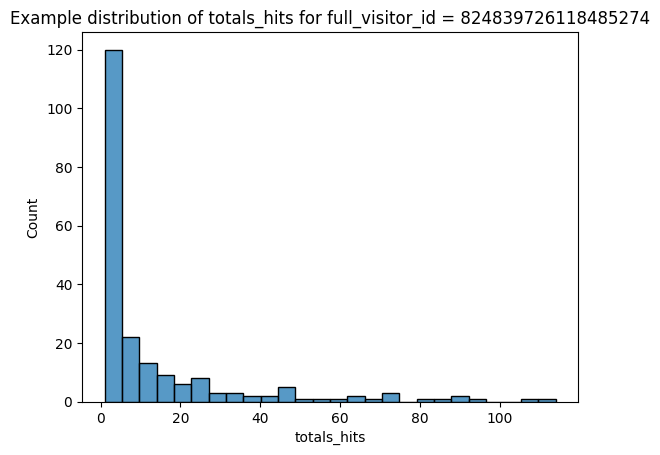

In [100]:
sns.histplot(data=res, x='totals_hits').set(title='Example distribution of totals_hits for full_visitor_id = 824839726118485274')

### 25.4 totals_time_on_site

In [101]:
totals_time_on_site_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_time_on_site', ['full_visitor_id'])

- This column is not recorded for majority of rows. Hence drop it

### 25.4 totals_new_visits

In [104]:
totals_new_visits_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_new_visits', ['full_visitor_id'])

- Drop totals_new_visits column

### 25.5 totals_session_quality_dim -> Drop column

### 25.6 totals_transactions

In [106]:
totals_transactions_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_transactions', ['full_visitor_id'])

In [108]:
totals_transactions_per_user_aggregates_df[~totals_transactions_per_user_aggregates_df['min_totals_transactions_per_session'].isnull()]

,full_visitor_id,min_totals_transactions_per_session,max_totals_transactions_per_session,avg_totals_transactions_per_session,median_totals_transactions_per_session,row_count
41,4077897320198403283,1.0,1.0,1.0,1.0,11
150,9029794295932939024,1.0,1.0,1.0,1.0,22
183,9099065750965948583,1.0,1.0,1.0,1.0,7
190,3159313764830847532,1.0,1.0,1.0,1.0,5
206,4705524295193430046,1.0,1.0,1.0,1.0,6
...,...,...,...,...,...,...
1328199,3293319129534135690,1.0,1.0,1.0,1.0,1
1328356,2691088667454863732,1.0,1.0,1.0,1.0,1
1328560,1591654165399055425,1.0,1.0,1.0,1.0,1
1328648,37806222406366969,1.0,1.0,1.0,1.0,1


In [109]:
con.execute("select CAST (totals_transactions AS DOUBLE) AS totals_transactions from intermediate_train_data where full_visitor_id = '4077897320198403283'").df()

,totals_transactions
0,NaN
1,1.0
2,NaN
3,NaN
4,NaN
5,NaN
6,1.0
7,NaN
8,NaN
9,NaN


In [110]:
intermediate_data_table

┌──────────────────┬──────────┬─────────────────────┬───┬──────────────────────┬──────────────────────┐
│ channel_grouping │   date   │   full_visitor_id   │ … │ traffic_source_adw…  │ unique_row_identif…  │
│     varchar      │  int64   │       varchar       │   │       boolean        │       varchar        │
├──────────────────┼──────────┼─────────────────────┼───┼──────────────────────┼──────────────────────┤
│ Direct           │ 20171212 │ 9473011094863798149 │ … │ NULL                 │ 947301109486379814…  │
│ Direct           │ 20171212 │ 1189911532486213486 │ … │ NULL                 │ 118991153248621348…  │
│ Direct           │ 20171212 │ 4657072248972713626 │ … │ NULL                 │ 465707224897271362…  │
│ Direct           │ 20171212 │ 3193781930413771251 │ … │ NULL                 │ 319378193041377125…  │
│ Direct           │ 20171212 │ 5257419468789915882 │ … │ NULL                 │ 525741946878991588…  │
│ Direct           │ 20171212 │ 9106048618306110722 │ … │ NULL  

In [20]:
intermediate_data_table.columns

['channel_grouping',
 'date',
 'full_visitor_id',
 'social_engagement_type',
 'visit_id',
 'visit_number',
 'visit_start_time',
 'geo_network_continent',
 'geo_network_sub_continent',
 'geo_network_country',
 'geo_network_region',
 'geo_network_metro',
 'geo_network_city',
 'geo_network_city_id',
 'geo_network_network_domain',
 'geo_network_latitude',
 'geo_network_longitude',
 'geo_network_network_location',
 'device_browser',
 'device_browser_version',
 'device_browser_size',
 'device_operating_system',
 'device_operating_system_version',
 'device_is_mobile',
 'device_mobile_device_branding',
 'device_mobile_device_model',
 'device_mobile_input_selector',
 'device_mobile_device_info',
 'device_mobile_device_marketing_name',
 'device_flash_version',
 'device_language',
 'device_screen_colors',
 'device_screen_resolution',
 'device_device_category',
 'totals_visits',
 'totals_hits',
 'totals_pageviews',
 'totals_time_on_site',
 'totals_new_visits',
 'totals_session_quality_dim',
 'tota

## TODO:
1. Delete social_engagement_type, geo_network_region, geo_network_metro, geo_network_city, geo_network_city_id, geo_network_network_domain, geo_network_latitude, geo_network_longitude, geo_network_network_location, device_browser_version, device_browser_size, device_operating_system_version, device_mobile_device_branding, device_mobile_device_model, device_mobile_input_selector, device_mobile_device_info, device_mobile_device_marketing_name, device_flash_version, device_language, device_screen_colors, device_screen_resolution, totals_time_on_site, totals_new_visits, totals_session_quality_dim
2. Convert visit_start_time to date. Also try to map it to local time where the person was located wrt UTC
3. Column: geo_network_continent, geo_network_sub_continent, geo_network_country, geo_network_region, geo_network_network_domain, device_operating_system => Replace (not set) with 'unknown'
4. Set datatype to numeric: totals_visits

## Ideas:
1. Can get income level for visitor from geo_network_city.??
2. FEATURE: Number of transactions/session